# Tree-based methods in Finance

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures).

## Introduction

Tree based methods are considered to be one of the most succesfull supervised learning methods, with high accuracy and stability. Random forest and gradient boosting algorithms are being popularly used in all kinds of data science problems after successfull performance in [forecasting competitions](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470996430.ch15) such as the [M3-Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions) and more recently on [Kaggle competitions](https://www.kaggle.com/competitions).

These very succesfull algorithms, such as the [XGBoost](https://syncedreview.com/2017/10/22/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition/) which we will cover in a [future lecture](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/momentum_with_regression_trees.ipynb) use resampling methods such as the ones we discussed in [previous lectures](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/cross_validation_in_fx.ipynb) to combine a large number of decision trees, resulting in great in prediction accuracy.

Here, we describe the most simple tree-based methods, using an application in Finance as illustration. Later, we will use those simple tree-based methods to produce more sophisticated algorithms after we introduce bagging, random forests, and boosting.

## Decision trees

Similarly to [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html), decision trees are constructed by stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given
observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods Tand are simple and useful for interpretation.

### Fitting and visualizing

Let get started by importing a few things and get right away to an example.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz

# get the signal data
carry_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='carry',index_col=0)
print('carry data has %s currencies and %s dates' % (carry_df.shape[1],carry_df.shape[0]))
value_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='value',index_col=0)
print('value data has %s currencies and %s dates' % (value_df.shape[1],value_df.shape[0]))

# get the tracker data
trackers_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='trackers',index_col=0)
print('trackers data has %s currencies and %s dates' % (trackers_df.shape[1],trackers_df.shape[0]))

# calculate future returns data
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

carry data has 24 currencies and 4973 dates
value data has 24 currencies and 4973 dates
trackers data has 24 currencies and 5220 dates
returns data has 24 currencies and 2241 dates


To make thigs simple, let's focus on a single currency, the BRL:

In [2]:
ccy = 'BRL'
y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)

# get the two signals
X_carry = carry_df[ccy].dropna().to_frame('s_carry')
X_value = value_df[ccy].dropna().to_frame('s_value')

# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()

# make sure the dates of the signals and future returns line up
yX = pd.concat([y,X],axis=1,sort=True).dropna()

Let's now use [scikit-learn tree package](https://scikit-learn.org/stable/modules/tree.html) to fit a decision tree to our data:

In [3]:
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf = tree_clf.fit(X, y)

So, we just "trained" our tree in our data. To visualize the tree we have just trained, we will use the export_graphviz method from [sci-kit learn tree package](https://scikit-learn.org/stable/modules/tree.html). You may need to install [graphviz](https://anaconda.org/anaconda/graphviz) and add '...\anaconda3\Library\bin\graphviz' to your PATH before running the next cell.

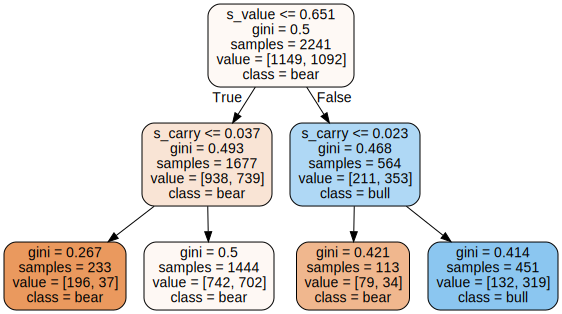

In [4]:
import graphviz
dot_data = export_graphviz(tree_clf, out_file=None,
                           feature_names=X.columns,
                           class_names=['bear','bull'],
                           rounded=True,filled=True)
graph = graphviz.Source(dot_data)
graph

### Interpreting

Decision trees are very intuitive to interpret (see [details here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)). The starting point is the root node, the first one in the tree above, we have the following recomendation:

* **root node**: first check if the BRL is cheap or rich. If the value signal is below 0.651, the currency is considered expensive and this is a **bear** signal.

If this is true, the currency is expensive, we will then check the carry signal in the left child node at depth 1. There were 1677 dates out of the 2241 in which that occurred.

* **left child node at depth 1**: check if the BRL has high or low carry. If the carry signal is below 0.037, the currency is considered low carry and this is a **bear** signal. There were 233 dates in which the BRL was expensive and had low carry and 1444 dates in which the BRL was expensive but had high carry.

Otherwise, the currency is cheap and we will then check the carry signal in the right child node at depth 1. There were 564 dates out of the 2241 in which that occurred.

* **right child node at depth 1**: check if the BRL has high or low carry. If the carry signal is below 0.023, the currency is considered low carry and this is a **bear** signal. There were 133 dates in which the BRL was cheap but had low carry and 451 dates in which the BRL was both cheap and had high carry.

We then arrive in the *leaf nodes* where the final decision is made. Actually, there is only one case there we have a *bull* signal which is the leaf node most to the right, when the currency was considered cheap (value signal > 0.651) and high carry (carry signal > 0.023).

##### Measures of impurity

The **Gini** impurity attribute of the node should be as low as possible. If all realizations of future returns match the label of that class, the Gini = 0 and the node is consider pure. It is measured as 

$$
G_{m} = \sum_{k=1}^{K} \hat{p}_{m,k}(1-\hat{p}_{m,k})
$$

where $\hat{p}_{m,k}$ represents the proportion of observations in node $m$ that correctly match the class $k$ label. For example, $\hat{p}_{bull}$ for the leaf node most to the right is given by $\hat{p}_{bull} = 319/451$.

An alternative measure of impurity is **cross-entropy**:

$$
CE_{m} = -\sum_{k=1}^{K} \hat{p}_{m,k}log(\hat{p}_{m,k})
$$

or the **error rate**:

$$
CE_{m} = 1-\max_{k=1}\hat{p}_{m,k}
$$

### Predicting

Let's say we are in a situation where $(s_{carry},s_{value} = (0.070,0.52)$, let's make a few predictions regarding the returnso of the BRLUSD over the next 21 business days:

In [5]:
current_signals = np.array([0.07,0.52])
prediction = 'bull' if tree_clf.predict([current_signals]) > 0 else 'bear'
probabilities = tree_clf.predict_proba([current_signals])
prob = probabilities[0][1*(prediction=='bull')]
print('The tree is predicting a %s market with a %s pct probability'
                                                  %(prediction,np.round(100*prob,2)))

The tree is predicting a bear market with a 51.39 pct probability


### Decision surface of a decision tree

Now that we know how to predict, we can look at the decision surface of our tree:

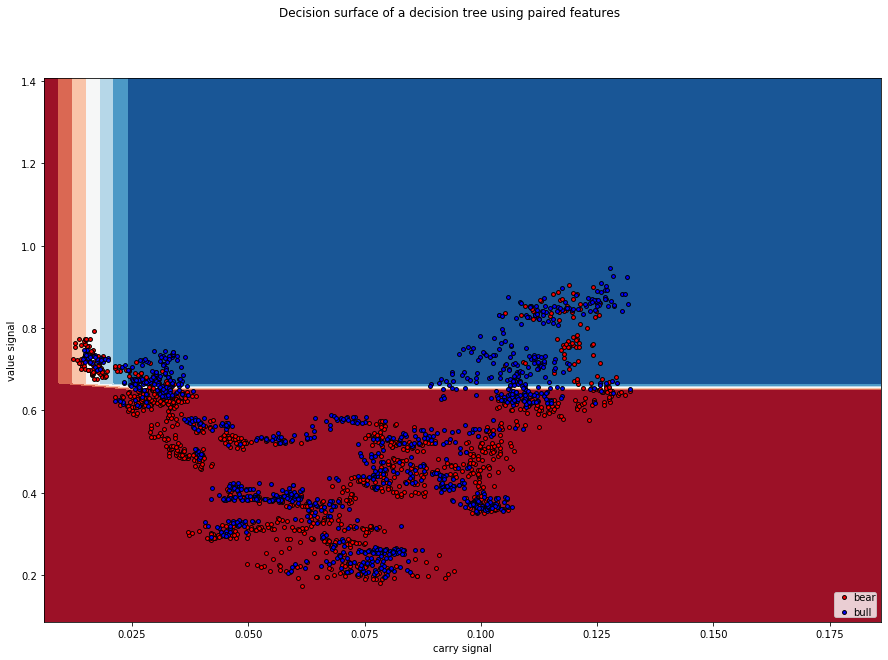

In [6]:
plot_step = 0.02

X = yX.iloc[:,1:].values
y = yX.iloc[:,0].values
c_min = 0.012236*0.5
c_max = 0.132118*1.5
v_min = 0.173784*0.5
v_max = 0.946179*1.5

xx, yy = np.meshgrid(np.arange(c_min, c_max, plot_step),
                     np.arange(v_min, v_max, plot_step))
plt.figure(figsize=(15,10))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
plt.xlabel('carry signal')
plt.ylabel('value signal')

# Plot the training points
for i, color in zip(range(2), "rb"):
    idx = np.where(y == i)
    market_class_name = ['bear','bull'][i]
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=market_class_name,
                cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.show()